# ***Radar Doppler Pulsado***

Luego de haber investigado sobre el modelo de radar pulsado para medir distancia se decidió implementar un radar doppler utilizando pulsaciones en vez de una onda continua.

Este tipo de radares se basa en emitir trenes de pulsos a una frecuencia determinada y utilizar el efecto Doppler para determinar la velocidad transversal relativa de los objetos, aquellos que se acerquen al radar aumentaran la frecuencia del eco producido, mientras que aquellos que se alejan disminuyen la frecuencia.

De la diferencia de las frecuencias nace el cálculo de la velocidad del objeto.





---


**Configuración del SDR y creación de la señal para la transmisión**

In [41]:
#Bibliotecas usadas para el funcionamiento del código

import adi
import numpy as np
from commpy.filters import rrcosfilter
from sk_dsp_comm import digitalcom as dc
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.fftpack import fftfreq
from scipy.linalg import bandwidth

import time

global nV
nV = 1200

In [42]:
#Configuracion de los parámetros del SDR a usar

#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = "ip:192.168.1.34"
SamplingRate     = 61e6           # Sample rate RX and TX paths[Samples/Sec]
Loopback         = 0             # 0=Disabled, 1=Digital, 2=RF

TxLOFreq         = 918e6        # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten          = -30             # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
TxRfBw           = 61e6          # Bandwidth of front-end analog filter of TX path [Hz]

RxLOFreq         = 918e6     # Carrier frequency of RX path [Hz]
GainControlModes = "slow_attack" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 0             # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz]
RxBufferSize     = 2**20-1

Definimos las carácterísticas del tren de pulso que vamos a utilizar


In [43]:
PRI = 0.01 #Se trata de un valor arbitrario, intervalo cada cuánto se repite el pulso (entre el inicio de un pulso y su antecesor)
PRF = 1/PRI #cantidad de pulsos por unidad de tiempo
potencia_señal = 1
c = 299792458 #velocidad de la luz en metros por segundo

pulses = 10 #cantidad de pulsos del radar

sample_f = SamplingRate
step = 1/SamplingRate #paso entre las muestras
f1 = 500e3
samples = pulses*int(PRI*SamplingRate) # PRI/step cantidad de muestras que necesito para un PRI.

Creación del array que almacenará los pulsos a utilizar, dónde cada pulso esta modulado por una onda sinusoidal de frecuencia f1 y duración $PRI = 10$*ms*

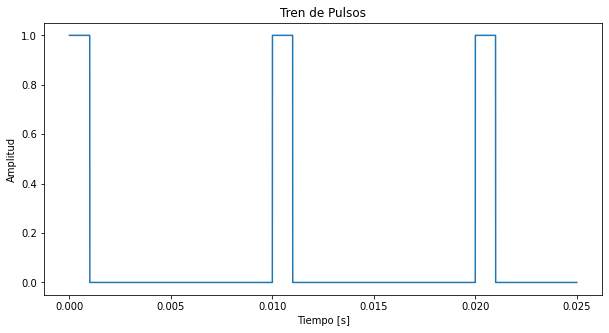

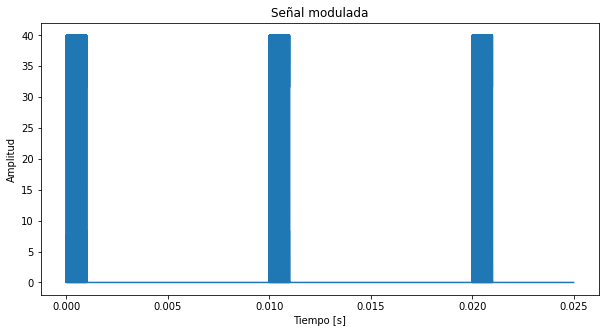

In [44]:
t = np.linspace(0,(samples-1)*step,samples) #Genera el array de valores de tiempo (1.800.000 valores separados cada <step> unidades de tiempo)
pulse_length = 0.001 #[s] => 0.001 duración del pulso en segundos
Tx_I = 20*np.sin(2*np.pi*f1*t) + 20
Tx_Q = 20*np.sin(2*np.pi*f1*t + np.pi/2) + 20
global zeros
zeros = np.zeros(len(t))  # arreglo completo
ones = np.ones(int(pulse_length*SamplingRate)) # señal continua de duracion pulse_length

for i in range(0,len(Tx_I),int(PRI*SamplingRate)):
      zeros[i:i+len(ones)] = ones #Cada un PRI, hacemos a la función zeros igual a 1 durante un tiempo <pulse_length> (es decir tenemos un tren de pulsos)

#graficamos el tren de pulsos
plt.figure(figsize=(10, 5))
plt.plot(t[:int(len(zeros)/4)],zeros[:int(len(zeros)/4)])
plt.title("Tren de Pulsos")
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.show()


#graficamos la señal modulada
Tx_I = Tx_I * zeros # parte real de la señal
Tx_Q = Tx_Q * zeros #parte imaginaria
Tx = Tx_I + 1j * Tx_Q

plt.figure(figsize=(10, 5))
plt.plot(t[:int(len(Tx)/4)],Tx[:int(len(Tx)/4)])
plt.title("Señal modulada")
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.show()

Configuración de la SDR

In [45]:
#-----------------------------------SDR Configurations-------------------------------
sdr             = adi.Pluto(Uri)
sdr.sample_rate = SamplingRate
sdr.loopback    = Loopback
#Tx:
sdr.tx_lo                 = int(TxLOFreq)
sdr.tx_hardwaregain_chan0 = TxAtten
sdr.tx_rf_bandwidth       = int(TxRfBw)
sdr.tx_buffer_size        = samples
sdr.tx_cyclic_buffer      = True
# Rx:
sdr.rx_lo                   = int(RxLOFreq)
sdr.gain_control_mode_chan0 = GainControlModes
sdr.rx_rf_bandwidth         = int(RxRfBw)
sdr.rx_cyclic_buffer        = True
sdr.rx_buffer_size          = RxBufferSize
sdr.rx_enabled_channels = [0]

Transmisión y recepción con dos SDR

In [1]:
sdr.rx_destroy_buffer()
sdr.tx_destroy_buffer()


#Inicio transmisión y recepción de la SDR
sdr.tx(Tx * (2**15-1))
sdr.rx()

time.sleep(1)

rxSignal = sdr.rx() / (2**15-1)


plt.figure(figsize=(10, 5))
plt.plot(t[:int(len(Tx)/4)],Tx[:int(len(Tx)/4)])
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(rxSignal[:int(len(Tx)/4)])
plt.show()




NameError: name 'sdr' is not defined

/tmp/ipykernel_33459/3732993565.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  pulso[j] = rxSignal[i]
/tmp/ipykernel_33459/3732993565.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  pulso[j] = rxSignal[i]


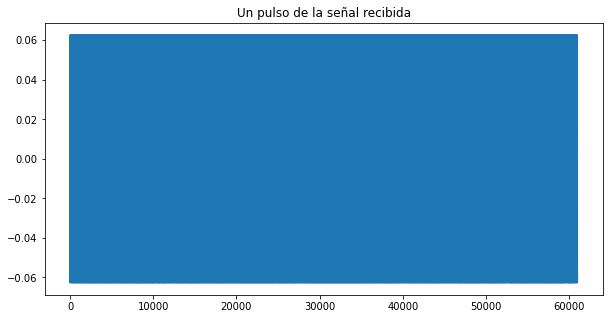

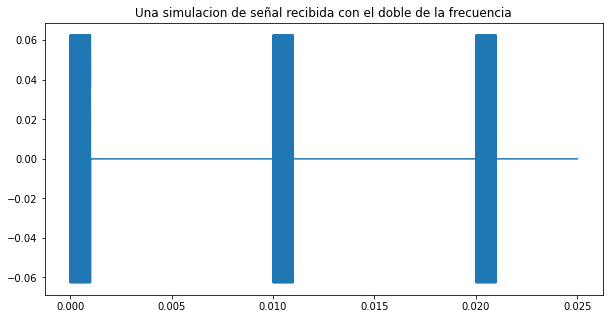

In [47]:
#Cambio de frecuencia de la señal recibida
pulso = np.zeros(int(pulse_length*SamplingRate))

i = 0
j = 0
paso = 0
tengoPrimero = 0
while i<len(rxSignal):
    if(rxSignal[i]>0.06 and paso==0):
        i += int(pulse_length*SamplingRate)
        paso=1
    elif(rxSignal[i]>0.06 and paso==1 and tengoPrimero==0):
        pulso[j] = rxSignal[i]
        tengoPrimero = 1
        j+=1
    elif(tengoPrimero==1):
        pulso[j] = rxSignal[i] 
        if(j==(pulse_length*SamplingRate - 1)):
            break
        j+=1
    i+=1
    
plt.figure(figsize=(10, 5))
plt.plot(pulso[:int(pulse_length*SamplingRate)])
plt.title("Un pulso de la señal recibida")
plt.show()

rxPrima = np.zeros(len(t))

new_freq = PRF / (1 + (nV/c))

for i in range(0,len(t),int(1/new_freq*SamplingRate)):
      rxPrima[i:i+len(pulso)] = pulso #Cada medio PRI, hacemos a la función zeros igual a un pulso recibido durante un tiempo <pulse_length> (es decir tenemos un tren de pulsos modulado)

plt.figure(figsize=(10, 5))
plt.plot(t[:int(len(rxPrima)/4)],rxPrima[:int(len(rxPrima)/4)])
plt.title("Una simulacion de señal recibida con otra frecuencia")
plt.show()

#### Rectificación y Matched Filter

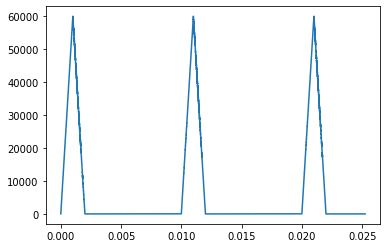

In [48]:
rx_rectified = np.abs(rxPrima) #rectificado de señal

rx_rec_filt = np.convolve(np.conjugate(Tx[:int(pulse_length*SamplingRate)]),rx_rectified,mode='full') 
plt.plot(t[:int(len(rx_rec_filt)/4)],rx_rec_filt[:int(len(rx_rec_filt)/4)])

In [49]:
#Cálculo de frecuencia de la señal recibida

# Inicializamos los máximos y sus índices para cada sección
max1 = float('-inf')
index_max1 = None

max2 = float('-inf')
index_max2 = None

# Encontramos el máximo en la primera sección
for indice, valor in enumerate(rx_rec_filt[:int(PRI*SamplingRate)]):
    if valor > max1:
        max1 = valor
        index_max1 = indice + 0

# Encontramos el máximo en la segunda sección
for indice, valor in enumerate(rx_rec_filt[int(PRI*SamplingRate):int(2*PRI*SamplingRate)]):
    if valor > max2:
        max2 = valor
        index_max2 = indice + int(PRI*SamplingRate)

dif =step *(index_max2 - index_max1)
print(dif)
fp = 1/(dif)
print("El PRF de la señal recibida es: " + str(fp) + "[Hz]")
    
    


0.010000032786885245
El PRF de la señal recibida es: 99.99967213222253[Hz]


In [50]:
#Calculo de la velocidad
# f' = f0*(v+v0)/(v-vs) = f0*(c+v0)/(c-vs) => vs = c - (f0*c/f') = c*(1-(f0/f'))
vs = c * (1 - (PRF / fp)) 

cadena=""

if(vs < 0):
    cadena = "El objeto se está alejando"
elif(vs > 0):
    cadena = "El objeto se está acercando"
elif(vs == 0):
    cadena = "El objeto está quieto"

print(cadena + " con una velocidad de " + str(abs(vs)) + "[m/s]")

El objeto se está alejando con una velocidad de 982.9260917627936[m/s]


Simulación utilizando buffers circulares

In [51]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
TxAtten  = -70
RxLOFreq = 2400e6
sdr.tx(np.zeros(1024))

In [52]:
# Destroy radio object
del(sdr)